In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import Tuple


In [2]:
class TaskDataset(Dataset):
    def __init__(self, ids, imgs, labels, transform=None):
        self.ids = ids
        self.imgs = imgs
        self.labels = labels
        self.transform = transform


    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
        label = int(self.labels[index])
        return id_, img, label

    def __len__(self):
        return len(self.ids)


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torch.load("./ModelStealingPub.pt")
ids = range(len(dataset.imgs))
public_dataset = TaskDataset(ids=ids, imgs=dataset.imgs, labels=dataset.labels, transform=transform)
public_dataset = DataLoader(dataset=public_dataset, batch_size=32, shuffle=True)


In [4]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(64*8*8, 128)
        )
        self.fc = nn.Linear(128, 44) 

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(F.dropout(x, p=0.5, training=self.training))
        x = self.fc(x)
        return F.softmax(x, dim=1)

In [5]:
def contrastive_loss(features, tau=0.5):
    batch_size = features.shape[0] // 2
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    features = F.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    mask = torch.eye(labels.shape[0], device=labels.device).bool()
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    logits = similarity_matrix / tau
    log_prob = F.log_softmax(logits, dim=1)
    loss = -log_prob * labels
    loss = loss.sum(1) / labels.sum(1)
    loss = loss.mean()
    return loss

In [6]:
encoder = CNNClassifier()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

In [7]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (_,images, labels) in enumerate(public_dataset):
        optimizer.zero_grad()
        output = encoder(images)
        loss = contrastive_loss(output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(public_dataset.dataset)}')

    losses.append(total_loss/len(public_dataset.dataset))

Epoch [1/10], Average Loss: 0.10739980984651125
Epoch [2/10], Average Loss: 0.10739580297470093
Epoch [3/10], Average Loss: 0.10739571700646328
Epoch [4/10], Average Loss: 0.10739584714632767
Epoch [5/10], Average Loss: 0.10739572736850152
Epoch [6/10], Average Loss: 0.10739579939842224
Epoch [7/10], Average Loss: 0.10739572737767146
Epoch [8/10], Average Loss: 0.10739580416679383
Epoch [9/10], Average Loss: 0.1074083674137409
Epoch [10/10], Average Loss: 0.10739604741793413


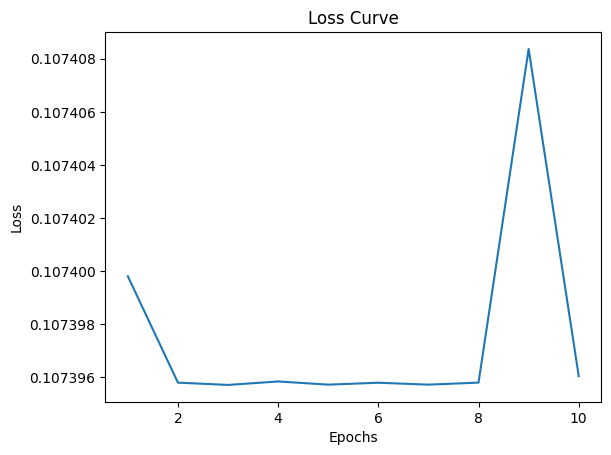

In [16]:
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [50]:
probabilities = []
encoder.eval()
with torch.no_grad():
    for batch_idx, (_,imgs, labels) in enumerate(public_dataset):
        outputs = encoder(imgs)
        probabilities.extend(outputs.numpy())


In [51]:
num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(probabilities)


In [52]:
print(cluster_labels)

[4 1 1 ... 0 2 1]


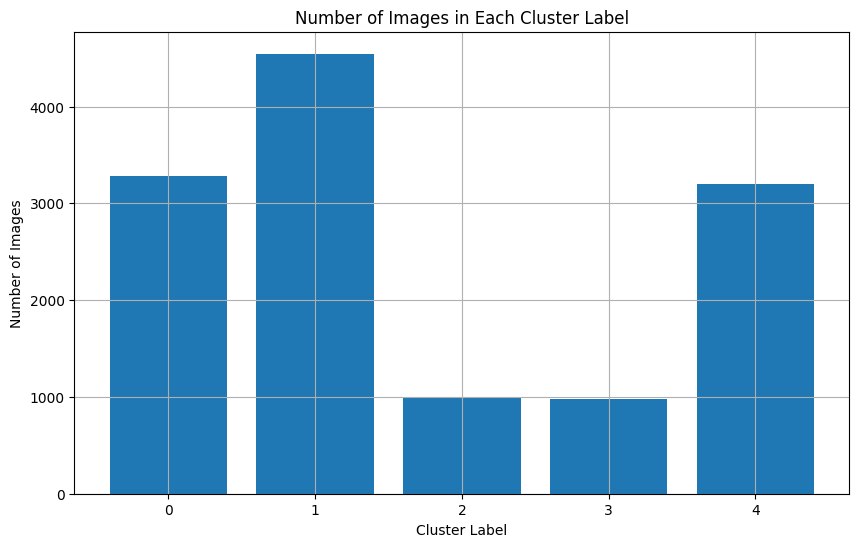

In [53]:
cluster_label_counts = np.zeros(5)
for cluster_id in range(5):
    cluster_label_counts[cluster_id] = np.sum(cluster_labels == cluster_id)

plt.figure(figsize=(10, 6))
plt.bar(range(5), cluster_label_counts, tick_label=range(5))
plt.xlabel('Cluster Label')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Cluster Label')
plt.grid(True)
plt.show()

In [54]:
cluster_buckets = {cluster_id: [] for cluster_id in range(5)}
for i in range(len(dataset.imgs)):
    cluster_buckets[cluster_labels[i]].append((dataset.imgs[i], dataset.labels[i]))

In [55]:
total = 0
for cluster_id, bucket in cluster_buckets.items():
    total += len(bucket)
    print(f'Cluster {cluster_id}: {len(bucket)} images')
print(f'Total: {total} images')

Cluster 0: 3283 images
Cluster 1: 4546 images
Cluster 2: 995 images
Cluster 3: 974 images
Cluster 4: 3202 images
Total: 13000 images
